In [1]:
%matplotlib inline
import numpy as np
import openmc

In [114]:
#create materials

#30% enriched Am
fuel = openmc.Material(1, "Am242m")
fuel.add_nuclide('Am242_m1', .3)
fuel.add_nuclide('Am241', .7)
fuel.set_density('g/cm3', .136) #low density to simulate dispersed particles
print(fuel)

#moderator
BeO = openmc.Material(2, "Be")
BeO.add_nuclide("Be9", .5)
BeO.add_nuclide('O16', .5)
BeO.set_density("g/cm3", 2.86)
print(BeO)

#reflector - ended up being better not using this
Pb = openmc.Material(3, 'Pb')
Pb.add_nuclide('Pb206', .25)
Pb.add_nuclide('Pb207', .25)
Pb.add_nuclide('Pb208', .5)
Pb.set_density('g/cm3', 11.34)
print(Pb)

#"D2 gas"
vac = openmc.Material(4, "H1")
vac.add_nuclide('H2',1.0)
vac.set_density('g/cm3',1.8e-5)
print(vac)

Material
	ID             =	1
	Name           =	Am242m
	Temperature    =	None
	Density        =	0.136 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Am242_m1       =	0.3          [ao]
	Am241          =	0.7          [ao]

Material
	ID             =	2
	Name           =	Be
	Temperature    =	None
	Density        =	2.86 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Be9            =	0.5          [ao]
	O16            =	0.5          [ao]

Material
	ID             =	3
	Name           =	Pb
	Temperature    =	None
	Density        =	11.34 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Pb206          =	0.25         [ao]
	Pb207          =	0.25         [ao]
	Pb208          =	0.5          [ao]

Material
	ID             =	4
	Name           =	H1
	Temperature    =	None
	Density        =	1.8e-05 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	H2             =	1.0          [ao]



/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)
/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Material instance already exists with id=4.
  warn(msg, IDWarning)


In [169]:
outer_rad = 60 #cm fuel outer radius
fuel_depth = .1 #cm thickness of aerogel/fuel material
vac_gap = 2 #cm distance between rings of moderator
mod_depth = 5 #thickness of moderator rings
height = 60
plate_height = 5
core_mod_rad = mod_depth/2
ref_depth = 5 #optional reflector layer

In [170]:
#define the layers
rad = core_mod_rad
rings = 0

#determines how many moderator/fuel/vacuum rings to include
while rad+vac_gap+mod_depth+2*fuel_depth < outer_rad:
    rings=rings + 1
    rad = rad + vac_gap + mod_depth + 2*fuel_depth

#will be populated with cells
vac_cells = []
mod_cells = []
fuel_cells = []

#defining useful surfaces
floor = openmc.ZPlane(z0=0, boundary_type='vacuum')
mid = openmc.ZPlane(z0=height, boundary_type='transmission')
top = openmc.ZPlane(z0=height+plate_height, boundary_type='transmission')
core_bound = openmc.ZCylinder(R=core_mod_rad, boundary_type='transmission')
outer_bound = openmc.ZCylinder(R=outer_rad, boundary_type='transmission')

#fill the center section with moderator
core = -core_bound & +floor & -mid
core_cell = openmc.Cell(fill = BeO, region = core)
mod_cells.append(core_cell)

#fill the top plate with moderator
plate = -outer_bound & +mid & -top
plate_cell = openmc.Cell(fill=BeO, region=plate)
mod_cells.append(plate_cell)

#geometric paramters
add = vac_gap+mod_depth+2*fuel_depth
layer_rad = core_mod_rad

#loop to create the cells that make up the fuel/moderator/vacuum rings
for i in range(0,rings):
    
    #define useful surfaces
    inner = openmc.ZCylinder(R=layer_rad+add*i, boundary_type='transmission')
    fuel_inner = openmc.ZCylinder(R=layer_rad+add*i+fuel_depth, boundary_type='transmission')
    fuel_outer = openmc.ZCylinder(R=layer_rad+add*i+vac_gap+fuel_depth, boundary_type='transmission')
    mod_inner = openmc.ZCylinder(R=layer_rad+add*i+vac_gap+2*fuel_depth, boundary_type='transmission')
    if i==rings-1:
        mod_outer = openmc.ZCylinder(R=outer_rad, boundary_type='transmission')
    else:
        mod_outer = openmc.ZCylinder(R=layer_rad+add*i+vac_gap+2*fuel_depth+mod_depth, boundary_type='transmission')
    
    #define the regions
    fuel_zone1 = +inner & -fuel_inner & +floor & -mid
    vac_zone = +fuel_inner & -fuel_outer & +floor & -mid
    fuel_zone2 = +fuel_outer & -mod_inner & +floor & -mid
    mod_zone = +mod_inner & -mod_outer & +floor & -mid
    
    #fill cells with material
    vac_cell = openmc.Cell(fill=vac, region=vac_zone)
    mod_cell = openmc.Cell(fill=BeO, region=mod_zone)
    fuel_cell1 = openmc.Cell(fill=fuel, region=fuel_zone1)
    fuel_cell2 = openmc.Cell(fill=fuel, region=fuel_zone2)
    
    #store the cells in variables outside the for loop
    vac_cells.append(vac_cell)
    mod_cells.append(mod_cell)
    fuel_cells.append(fuel_cell1)
    fuel_cells.append(fuel_cell2)

#add reflector/moderator around it all
outest_bound = openmc.ZCylinder(R=outer_rad+ref_depth, boundary_type='vacuum')
topest = openmc.ZPlane(z0 = height+plate_height+ref_depth, boundary_type='vacuum')
ref_zone = +top & -topest & -outest_bound
ref_cell = openmc.Cell(fill=BeO, region=ref_zone)
ref2_zone = +floor & -top & +outer_bound & -outest_bound
ref2_cell = openmc.Cell(fill=BeO, region=ref2_zone)

#create the universe
hall_cells = vac_cells + mod_cells + fuel_cells + [ref_cell, ref2_cell]
uni = openmc.Universe(cells=hall_cells)

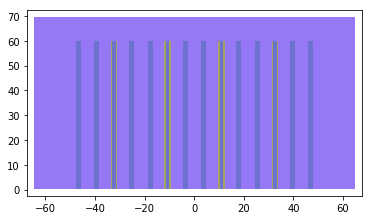

In [171]:
#visualize the geometry
uni.plot(width=(2*(outer_rad+ref_depth)+5, height+plate_height+ref_depth+5), origin = (0,0,(height+plate_height+ref_depth)/2), basis='xz', color_by='material')

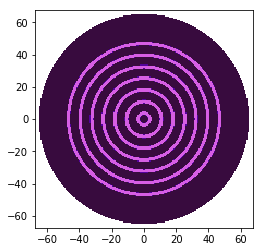

In [172]:
uni.plot(width=(2*(outer_rad+ref_depth)+5, 2*(outer_rad+ref_depth)+5), origin = (0,0,height/2), basis='xy', color_by='material')

In [173]:
#create root universe
geom = openmc.Geometry()
geom.root_universe = uni

#configure statistics geometry
#source = openmc.stats.Box((-20, -20, 0), (20, 20, fuel_depth))
source = openmc.stats.Point((core_mod_rad+vac_gap/2,0,height/2))
src = openmc.Source(space=source)

#export geometry
geom.export_to_xml()

In [174]:
#create materials & cross sections xmls
mats = openmc.Materials()
mats.cross_sections = '/home/james/nndc_hdf5/cross_sections.xml' #comment this out/replace if you need to
mats.append(fuel)
mats += [BeO]
mats += [vac]
mats += [Pb]

#export materials
mats.export_to_xml()

In [175]:
settings = openmc.Settings()
settings.particles = 1000
settings.batches = 20
settings.inactive = 10
settings.source = src
settings.export_to_xml()

In [176]:
#configure tallies
cell_filter = openmc.CellFilter(fuel_cells)
t = openmc.Tally(4)
t.filters = [cell_filter]
t.scores = ['fission']
tallies = openmc.Tallies([t])

#export tallies
tallies.export_to_xml()

/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Tally instance already exists with id=4.
  warn(msg, IDWarning)


In [177]:
openmc.run()

openmc: Relink `/home/james/anaconda3/bin/../lib/./libgfortran.so.4' with `/lib/x86_64-linux-gnu/librt.so.1' for IFUNC symbol `clock_gettime'

                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               ####################

0